# Exploring Dandiset 001433: Breathing Rhythm and Place Dataset

*Generated with the assistance of AI. Please review all code and outputs carefully and verify results in your independent analyses.*

## Overview

**Dandiset 001433** ("Breathing rhythm and place dataset") contains behavioral and electrophysiological data from freely-behaving mice. The dataset includes simultaneous local field potential (LFP) recordings from the olfactory bulb and sniff (respiratory) thermistor readings, along with extracted inhalation and exhalation event times.  

- **Dandiset link:** [https://dandiarchive.org/dandiset/001433/0.250507.2356](https://dandiarchive.org/dandiset/001433/0.250507.2356)
- **Data standard:** NWB (Neurodata Without Borders)
- **Subjects:** Mouse (Mus musculus), 4 animals, multiple sessions
- **Experimental details:** No imposed stimuli, focusing on natural breathing and neural activity

This notebook demonstrates how to access, load, and explore one of the NWB files in this dandiset directly from the remote archive.

## What this notebook covers

- How to list and select NWB files in Dandiset 001433 using the DANDI API
- How to load LFP (electrophysiology) and sniffing signals remotely from NWB
- How to visualize:
    - LFP and sniff signals for the first 10 seconds
    - Overlayed inhalation and exhalation events on the sniff trace
- A summary of the file structure and contents

## Required Packages

This notebook assumes the following packages are installed in your Python environment:

- `numpy`
- `matplotlib`
- `pynwb`
- `h5py`
- `remfile`
- `dandi` (DANDI API client)

## List available NWB assets in Dandiset 001433

We first use the DANDI API to see which NWB files are available in this Dandiset.

In [1]:
from dandi.dandiapi import DandiAPIClient

dandiset_id = "001433"
dandiset_version = "0.250507.2356"

# Start API client and get a list of NWB assets
client = DandiAPIClient()
dandiset = client.get_dandiset(dandiset_id, dandiset_version)

# List the first 10 NWB files (for demonstration)
assets = dandiset.get_assets_by_glob("*.nwb")
nwb_file_names = [asset.path for asset in list(assets)[:10]]
print("Example NWB files in Dandiset 001433:")
for fname in nwb_file_names:
    print(fname)

Example NWB files in Dandiset 001433:
sub-4122/sub-4122_ses-20250507T152927_ecephys.nwb
sub-4122/sub-4122_ses-20250507T152930_ecephys.nwb
sub-4122/sub-4122_ses-20250507T152933_ecephys.nwb
sub-4127/sub-4127_ses-20250507T152941_ecephys.nwb
sub-4127/sub-4127_ses-20250507T152953_ecephys.nwb
sub-4127/sub-4127_ses-20250507T153010_ecephys.nwb
sub-4127/sub-4127_ses-20250507T153020_ecephys.nwb
sub-4127/sub-4127_ses-20250507T153032_ecephys.nwb
sub-4127/sub-4127_ses-20250507T153048_ecephys.nwb
sub-4127/sub-4127_ses-20250507T153100_ecephys.nwb


In this notebook, we will focus on the following file:

```
sub-4122/sub-4122_ses-20250507T152927_ecephys.nwb
```

## Access remote NWB file for session sub-4122/sub-4122_ses-20250507T152927_ecephys.nwb

In [2]:
import h5py
import remfile
import pynwb

nwb_path = "sub-4122/sub-4122_ses-20250507T152927_ecephys.nwb"
asset = next(dandiset.get_assets_by_glob(nwb_path))
url = asset.download_url

# Open NWB file for streaming (do not download entire file)
remote_file = remfile.File(url)
h5_file = h5py.File(remote_file, 'r')
io = pynwb.NWBHDF5IO(file=h5_file, load_namespaces=True)
nwb = io.read()

print("Loaded NWB file:", nwb_path)

Loaded NWB file: sub-4122/sub-4122_ses-20250507T152927_ecephys.nwb


/home/magland/miniconda3/envs/dev/lib/python3.12/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.8.0 because version 2.7.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


## Load and visualize the first 10 seconds of LFP and Sniff Thermistor Signals

Both signals are sampled at 1000 Hz. Here, we'll plot:
- The first LFP channel (out of 16)
- The sniff thermistor (respiration) trace

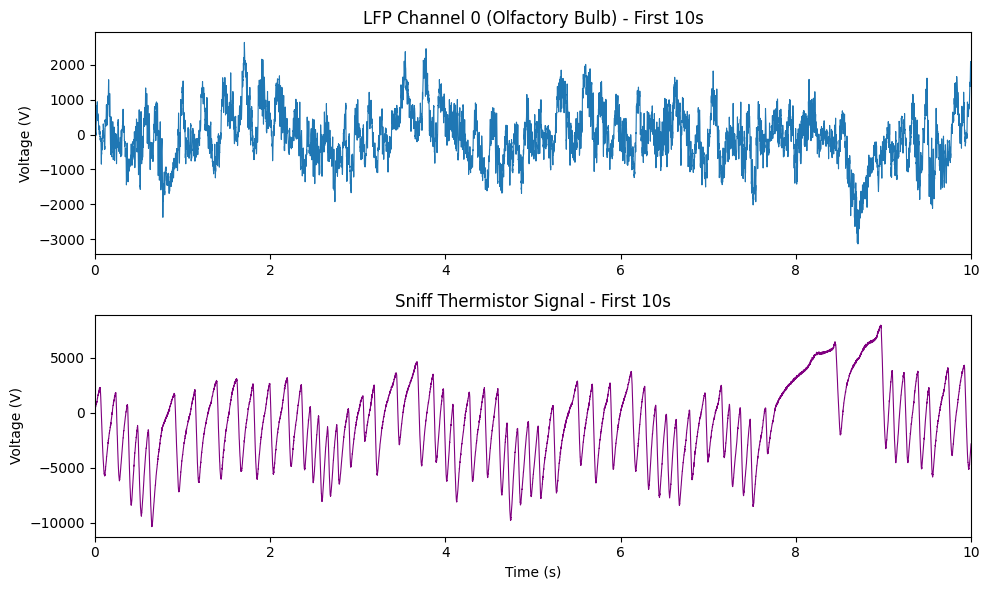

In [3]:
import numpy as np
import matplotlib.pyplot as plt

duration_sec = 10
lfp = nwb.acquisition['LFP']
sniff = nwb.acquisition['SniffSignal']
sample_rate = int(lfp.rate)
n_samples = duration_sec * sample_rate

# Load LFP (all channels) and sniff signals (first 10 seconds)
lfp_data = lfp.data[:n_samples, :]    # (samples, channels)
sniff_data = sniff.data[:n_samples]   # (samples,)
time = np.arange(n_samples) / sample_rate

plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(time, lfp_data[:, 0], lw=0.8)
plt.title('LFP Channel 0 (Olfactory Bulb) - First 10s')
plt.ylabel('Voltage (V)')
plt.xlim([0, duration_sec])

plt.subplot(2, 1, 2)
plt.plot(time, sniff_data, color='purple', lw=0.8)
plt.title('Sniff Thermistor Signal - First 10s')
plt.ylabel('Voltage (V)')
plt.xlabel('Time (s)')
plt.xlim([0, duration_sec])

plt.tight_layout()
plt.show()

## Overlay Inhalation and Exhalation Events on the Sniff Trace

The NWB behavioral processing module stores inhalation and exhalation events (timestamps in milliseconds).  
We'll visualize both on the sniff trace for the first 10 seconds:
- Inhalations: blue dashed lines
- Exhalations: red dotted lines

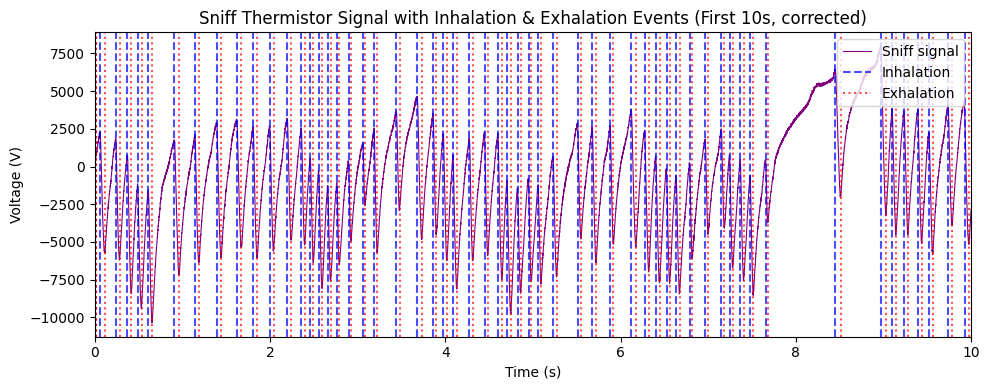

In [4]:
# Access behavioral event times from the processing module
behavior_mod = nwb.processing['behavior']
inhalation = behavior_mod.data_interfaces['inhalation_time']
exhalation = behavior_mod.data_interfaces['exhalation_time']

# Convert event times from ms to seconds and select those in the first 10s
inhalation_times_sec = inhalation.timestamps[:] / 1000.0
exhalation_times_sec = exhalation.timestamps[:] / 1000.0
inhale_times_plot = inhalation_times_sec[inhalation_times_sec <= duration_sec]
exhale_times_plot = exhalation_times_sec[exhalation_times_sec <= duration_sec]

plt.figure(figsize=(10, 4))
plt.plot(time, sniff_data, color='purple', lw=0.8, label='Sniff signal')
for idx, t in enumerate(inhale_times_plot):
    plt.axvline(x=t, color='b', alpha=0.7, linestyle='--', label='Inhalation' if idx == 0 else "")
for idx, t in enumerate(exhale_times_plot):
    plt.axvline(x=t, color='r', alpha=0.7, linestyle=':', label='Exhalation' if idx == 0 else "")
plt.title('Sniff Thermistor Signal with Inhalation & Exhalation Events (First 10s, corrected)')
plt.xlabel('Time (s)')
plt.ylabel('Voltage (V)')
plt.xlim([0, duration_sec])
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

## Summary of NWB File Contents

The session file `sub-4122/sub-4122_ses-20250507T152927_ecephys.nwb` contains:

- **Electrophysiology:** 16-channel LFP recording from the olfactory bulb, sampled at 1000 Hz
- **Sniffing signal:** 1-channel thermistor voltage (respiration), sampled at 1000 Hz
- **Behavioral events:** Inhalation and exhalation times (as event series, in milliseconds)
- **Device and electrode metadata:** Standard NWB tables describing 16 recording electrodes and their grouping
- **Subject and session metadata:** Species, sex, age, experiment/recording/lab details

There are no spike/unit (sorted) data, additional behavioral modules, or other continuous or video modalities in this file.

## Next Steps

You have now learned how to:
- Discover and access NWB assets from a Dandiset using the DANDI API
- Load and visualize neural and sniffing behavioral data
- Align and plot annotated inhalation/exhalation events over raw respiration traces

This notebook provides a foundation for further analyses, such as spectral, event-triggered, or time-frequency investigations of olfactory bulb neural activity in relation to the sniff cycle.